### Imports

In [1]:
import pandas as pd
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
import numpy
import csv

## Data Dictionary


### Dataset: `lidc-idri-nodule-counts-6-23-2015.xlsx`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | Pode repetir (paciente com vários TACs). |
| **Number of Nodules** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” ou “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC. | 0, 1, 2, ... | 0 = sem nódulos. |
| **Nodules ≥3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC (independentemente da forma como os outros radiologistas marcaram a lesão). | 0, 1, 2, ... | — |
| **Nodules <3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” de pelo menos um dos quatro radiologistas do LIDC (sem que nenhum radiologista tenha atribuído à lesão uma marcação de “nódulo ≥ 3 mm”). | 0, 1, 2, ... | — |
| **Unnamed: 4** | — | Coluna sem informação. | — | Removida por não conter dados relevantes. |
| **Unnamed: 5** | — | Coluna explicativa. | — | Removida por não conter dados relevantes. |




### Dataset: `tcia-diagnosis-data-2012-04-20.xls`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | — |
| **Patient Diagnosis** | `int` | Diagnóstico do paciente. | 1 = Benigno, 2 = Maligno Primário | Valores 0 (Desconhecido) e 3 (Metastático) foram removidos do dataset. |
| **Patient Diagnosis Method** | `string` | Método de diagnóstico. | `"Histology"`, `"Clinical"` | — |
| **Primary tumor site for metastatic disease** | `string` | Local de origem do tumor metastático. | `"Lung"`, `"Breast"`, ... | Normalmente vazio; apenas preenchido para casos metastáticos (removidos do dataset). |
| **Nodule 1 Diagnosis** | `int` | Diagnóstico do nódulo 1. | -1 = Desconhecido, 1 = Benigno, 2 = Maligno Primário, 3 = Metastático | Valores NaN convertidos para -1. |
| **Nodule 1 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 1. | `"Histology"`, `"Clinical"` | — |
| **Nodule 2 Diagnosis** | `int` | Diagnóstico do nódulo 2. | -1, 1, 2, 3 | Valores NaN convertidos para -1. |
| **Nodule 2 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 2. | `"Histology"`, `"Clinical"` | — |
| **Nodule 3 Diagnosis** | `int` | Diagnóstico do nódulo 3. | -1, 1, 2, 3 | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 3 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 3. | `"Histology"`, `"Clinical"` | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis** | `int` | Diagnóstico do nódulo 4. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 4. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis** | `int` | Diagnóstico do nódulo 5. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 5. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |

### Número de nódulos por paciente.

In [2]:
nodules = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')

In [3]:
nodules.columns

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')

In [4]:
nodules.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


In [5]:
nodules.isna().sum()

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64

Como as colunas 4 e 5 não parecem ter informação relevante, podemos apenas apagá-las sem problemas.

In [6]:
nodules = nodules.iloc[:, :-2]

#### Aproveitamos para renomear o nome das colunas

In [7]:
nodules.columns = ['Patient_ID', 'Number of Nodules', 'Nodules >=3mm', 
                         'Nodules <3mm']

Falta procurar o último NaN que existe.

In [8]:
nan_rows = nodules[nodules.isnull().any(axis=1)]
nan_rows.head()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1018,NaN,7371,2669,4702


Que facilmente descobrimos vir da última linha, que apenas serve para somar todas as quantidades.
Eliminamos então essa linha..

In [9]:
nodules = nodules.drop(nodules.index[-1])

... e confirmamos se foi corretamente eliminada.

In [10]:
nodules.tail()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1013,LIDC-IDRI-1008,7,6,1
1014,LIDC-IDRI-1009,2,1,1
1015,LIDC-IDRI-1010,10,1,9
1016,LIDC-IDRI-1011,4,4,0
1017,LIDC-IDRI-1012,1,1,0


#### Últimas verificações

In [11]:
nodules['Patient_ID'].nunique()

1010

Mas anteriormente vimos que existem 1018 entradas, logo, existem entradas repetidas. Vamos descobrir quais.

In [12]:
nodules[nodules['Patient_ID'].duplicated(keep=False)]

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
131,LIDC-IDRI-0132,14,6,8
132,LIDC-IDRI-0132,12,8,4
151,LIDC-IDRI-0151,3,1,2
152,LIDC-IDRI-0151,7,1,6
315,LIDC-IDRI-0315,13,7,6
316,LIDC-IDRI-0315,8,5,3
333,LIDC-IDRI-0332,6,5,1
334,LIDC-IDRI-0332,3,2,1
357,LIDC-IDRI-0355,4,1,3
358,LIDC-IDRI-0355,3,2,1


Descobrimos então que afinal não são entradas repetidas, mas sim que alguns pacientes fizeram vários TACs! Isto é confirmado ao ir-se ao dataset. Podemos manter todas estas entradas, mas temos de guardar cada um destes pacientes e tratar ambos os seus TACs como casos diferentes!

In [13]:
multiple_entries = nodules[nodules['Patient_ID'].duplicated(keep=False)]['Patient_ID'].unique().tolist()
multiple_entries = [s[10:] for s in multiple_entries] # Retirar o 'LIDC-IDRI-' do nome
multiple_entries

['0132', '0151', '0315', '0332', '0355', '0365', '0442', '0484']

### Diagnóstico dos pacientes

In [14]:
diagnosis = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')

Vamos limpar o nome das colunas

In [15]:
diagnosis.columns = ['Patient_ID', 'Patient Diagnosis', 'Patient Diagnosis Method', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis', 'Nodule 1 Diagnosis Method', 
                         'Nodule 2 Diagnosis', 'Nodule 2 Diagnosis Method', 
                         'Nodule 3 Diagnosis', 'Nodule 3 Diagnosis Method',
                         'Nodule 4 Diagnosis', 'Nodule 4 Diagnosis Method',
                         'Nodule 5 Diagnosis', 'Nodule 5 Diagnosis Method']
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notamos que existem várias colunas com valores a NaN, há necessidade?

In [16]:
diagnosis.isna().sum()

Patient_ID                                     0
Patient Diagnosis                              0
Patient Diagnosis Method                       0
Primary tumor site for metastatic disease      0
Nodule 1 Diagnosis                            20
Nodule 1 Diagnosis Method                     20
Nodule 2 Diagnosis                           137
Nodule 2 Diagnosis Method                    137
Nodule 3 Diagnosis                           156
Nodule 3 Diagnosis Method                    156
Nodule 4 Diagnosis                           157
Nodule 4 Diagnosis Method                    157
Nodule 5 Diagnosis                           157
Nodule 5 Diagnosis Method                    157
dtype: int64

Como o dataset tem 157 entradas, as últimas 4 colunas nunca possuem dados. Facilmente vemos que o único valor que existe na outra coluna é apenas erro de leitura.

In [17]:
diagnosis[~pd.isna(diagnosis['Nodule 3 Diagnosis'])]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
114,LIDC-IDRI-0285,3,3,melanoma,3.0,3.0,0.0,0.0,,,NaN,NaN,NaN,NaN


Portanto, podemos simplesmente apagar estas 3 colunas.

In [18]:
diagnosis = diagnosis.iloc[:, :-6]
diagnosis.head(3)

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN


In [19]:
diagnosis.dtypes

Patient_ID                                    object
Patient Diagnosis                              int64
Patient Diagnosis Method                       int64
Primary tumor site for metastatic disease     object
Nodule 1 Diagnosis                           float64
Nodule 1 Diagnosis Method                    float64
Nodule 2 Diagnosis                           float64
Nodule 2 Diagnosis Method                    float64
dtype: object

Os valores dos nódulos 1 e 2 deviam ser sempre inteiros, visto que são apenas classificações. Para convertermos uma coluna de floats em inteiros precisamos primeiro que não existam NaNs. Para isso, vamos primeiro converter todos os valores NaN em -1.

In [20]:
cols = diagnosis.columns[4:8]  # select the numeric columns explicitly
diagnosis[cols] = diagnosis[cols].apply(lambda x: x.fillna(-1).astype(int))
print(diagnosis.dtypes)
diagnosis.head(3)

Patient_ID                                   object
Patient Diagnosis                             int64
Patient Diagnosis Method                      int64
Primary tumor site for metastatic disease    object
Nodule 1 Diagnosis                            int64
Nodule 1 Diagnosis Method                     int64
Nodule 2 Diagnosis                            int64
Nodule 2 Diagnosis Method                     int64
dtype: object


,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3,4,-1,-1
1,LIDC-IDRI-0071,3,1,Head & Neck,1,1,-1,-1
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1


In [21]:
diagnosis[diagnosis['Nodule 1 Diagnosis'] == -1]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
120,LIDC-IDRI-0314,2,2,adenocarcinoma,-1,-1,-1,-1
121,LIDC-IDRI-0325,2,2,squamous cell carcinoma/non-small cell,-1,-1,-1,-1
126,LIDC-IDRI-0405,1,2,reactive mesothelial cells,-1,-1,-1,-1
127,LIDC-IDRI-0454,2,2,non-small cell carcinoma,-1,-1,-1,-1
130,LIDC-IDRI-0510,1,2,focal fibrosis,-1,-1,-1,-1
131,LIDC-IDRI-0522,2,2,Adenocarcinoma,-1,-1,-1,-1
132,LIDC-IDRI-0543,2,2,small cell carcinoma,-1,-1,-1,-1
134,LIDC-IDRI-0562,2,3,adenocarcinoma,-1,-1,-1,-1
136,LIDC-IDRI-0576,0,2,reactive mesothelial cells,-1,-1,-1,-1
139,LIDC-IDRI-0624,1,3,Histoplasmosis with necrotizing granulomas,-1,-1,-1,-1


Basicamente:  
Paciente é diagnosticado com cancro pulmonar, mas não há informação acerca dos nódulos. ChatGPT disse:

If your model predicts cancer at the nodule level:  
→ Exclude nodules with missing labels.  

If your model predicts cancer at the patient level:  
→ Keep these patients, but make sure your data aggregation handles missing nodules.

No ficheiro ```tcia-diagnosis-data-2012-04-20.xls``` temos 2 dados que nos são relevantes: **Diagnósitco do Paciente** e **Diagnóstico do Nódulo**
- Desconhecido
- Benigno
- Maligno (Cancro de Pulmão Primário)
- Maligno (Metastático)

Vamos ignorar pacientes cujo diagnóstico é desconhecido, pois estes não têm interesse nenhum ao nosso objetivo final, estaríam apenas a adicionar ruído que pode enganar o modelo.  
Também vamos ignorar cancros Malignos Metastáticos. Estes são cancros cujo local de origem é outra área do corpo, o nosso objetivo não é diferenciar cancro de pulmão primário de cancro metastático. Características visuais podem ser diferentes, confundindo o modelo.

In [22]:
diagnosis = diagnosis[(diagnosis['Patient Diagnosis'] != 0) & (diagnosis['Patient Diagnosis'] != 3)]
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1
4,LIDC-IDRI-0090,2,3,NSCLC,2,3,-1,-1
12,LIDC-IDRI-0138,2,2,Lung Cancer,2,2,-1,-1
14,LIDC-IDRI-0149,1,1,chondrosarcoma,1,1,-1,-1
17,LIDC-IDRI-0162,1,1,gallbladder,1,1,-1,-1
...,...,...,...,...,...,...,...,...
150,LIDC-IDRI-0939,2,3,RUL Small cell,2,3,-1,-1
151,LIDC-IDRI-0965,2,3,Adenocarcinoma,-1,-1,-1,-1
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2,3,-1,-1
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,-1,-1,-1,-1


Foram removidas 78 entradas (157 - 79).

In [23]:
diagnosis[diagnosis['Nodule 2 Diagnosis'] == 3]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
27,LIDC-IDRI-0174,2,3,nonsmall cell lung cancer,2,3,3,4
58,LIDC-IDRI-0214,2,3,non small cell lung,2,3,3,4
128,LIDC-IDRI-0470,2,2,nonsmall cell lung cancer,2,2,3,4


### Criação de um dataset com todas as anotações

In [24]:
# Obtém todos os scans disponíveis
def gen_dataset():
    scans = pl.query(pl.Scan).all()
    
    if not scans:
        print("No scans found, verify if the path is correct.")
        exit(1)
    
    with open('data.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # cabeçalho
        writer.writerow([
            'NoduloID', 'Num Annotations',
            'Malignancy', 'Calcification', 'Internal Structure',
            'Spiculation', 'Margin', 'Subtlety',
            'Lobulation', 'Texture', 'Sphericity',
            'Volume',
            'Slice Thickness (mm)', 'Pixel Resolution'
        ])
        
        for scan in scans:
    
            nodulos = scan.cluster_annotations()
            num_nodulos = len(nodulos)
    
            slice_thickness = scan.slice_thickness
            pixel_spacing = scan.pixel_spacing
            
            # Verifica se existem nódulos
            if num_nodulos == 0:
                writer.writerow([
                    scan.patient_id[-4:], 0,
                    None, None, None, 
                    None, None, None, 
                    None, None, None,
                    None,
                    slice_thickness, pixel_spacing
                ])
            else:
                for idx, nodulo in enumerate(nodulos):
                    
                    num_an = len(nodulo)
    
                    nod_id = scan.patient_id[-4:] + f"-{idx+1}"
    
                                    
                    for anotacao in nodulo:
    
                        writer.writerow([
                            nod_id, num_an,
                            anotacao.malignancy, anotacao.calcification, anotacao.internalStructure,
                            anotacao.spiculation, anotacao.margin, anotacao.subtlety, 
                            anotacao.lobulation, anotacao.texture, anotacao.sphericity,
                            anotacao.volume,
                            slice_thickness, pixel_spacing
                            
                        ])
    
    print("Finished generating .csv file.")

# Convertido em função para não correr sempre que se dá run a tudo do notebook
# gen_dataset()

In [25]:
annotation_data = pd.read_csv('data.csv')
annotation_data = annotation_data.sort_values(by="NoduloID")
annotation_data = annotation_data.reset_index(drop=True)
annotation_data.to_csv('data.csv', index=False)
annotation_data.head()

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641


In [26]:
filtered = annotation_data[annotation_data['Num Annotations'] > 4]
filtered

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
490,0055-1,6,4.0,6.0,1.0,2.0,1.0,4.0,1.0,4.0,4.0,176.742554,2.5,0.703125
491,0055-1,6,2.0,6.0,1.0,1.0,5.0,3.0,3.0,5.0,3.0,1751.358032,2.5,0.703125
492,0055-1,6,4.0,6.0,1.0,2.0,3.0,4.0,3.0,4.0,4.0,292.304993,2.5,0.703125
493,0055-1,6,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,205.169678,2.5,0.703125
494,0055-1,6,3.0,6.0,1.0,2.0,3.0,3.0,2.0,4.0,3.0,244.720459,2.5,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,0942-1,7,4.0,6.0,1.0,3.0,1.0,5.0,2.0,3.0,5.0,3621.512604,1.0,0.742188
6568,0942-1,7,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,1169.438171,1.0,0.742188
6569,0942-1,7,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,2866.307831,1.0,0.742188
6570,0942-1,7,5.0,6.0,1.0,2.0,4.0,5.0,1.0,5.0,4.0,4970.800781,1.0,0.742188


In [27]:
wrong_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(wrong_nodule)} nodulos com anotações erradas")
wrong_nodule = [s[:4] for s in wrong_nodule.tolist()]
print(wrong_nodule)

Existem 14 nodulos com anotações erradas
['0055', '0092', '0137', '0204', '0252', '0332', '0340', '0366', '0404', '0608', '0815', '0863', '0865', '0942']


In [28]:
def print_all_ann(id: str, idx: list):
    %matplotlib inline
    
    # Select scan by patient ID
    pid = "LIDC-IDRI-" + id
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    
    if not scan:
        raise ValueError(f"No scan found for patient {pid}")
    
    anns = scan.annotations
    print(f"Found {len(anns)} annotations for patient {scan.patient_id}")
    
    for i, ann in enumerate(anns, 1):
        if (i in idx):
            ann.visualize_in_scan(False)

Found 8 annotations for patient LIDC-IDRI-0366


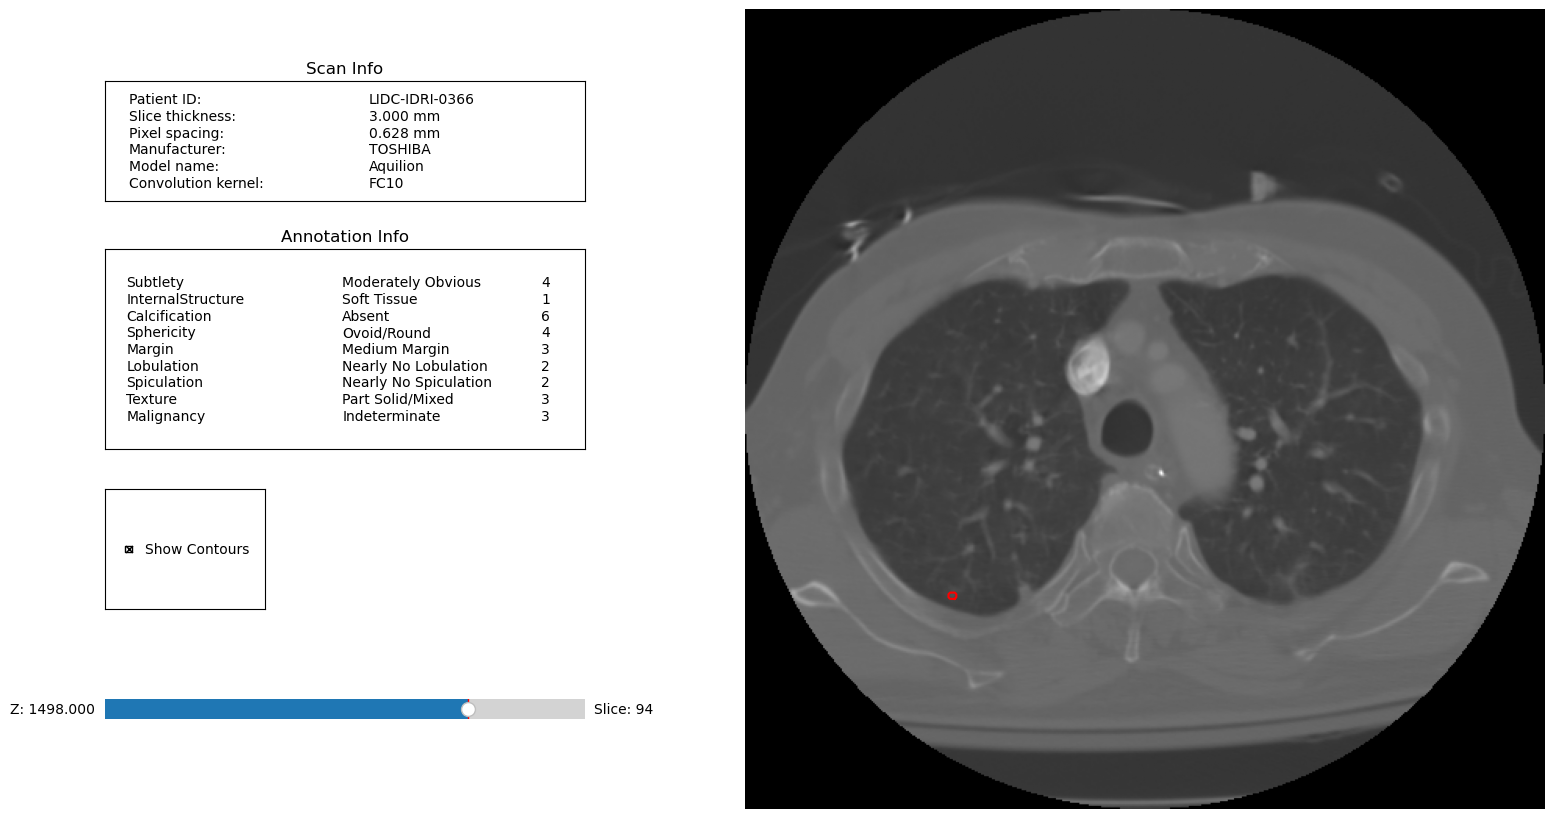

In [29]:
print_all_ann("0366", [2])

Found 8 annotations for patient LIDC-IDRI-0340


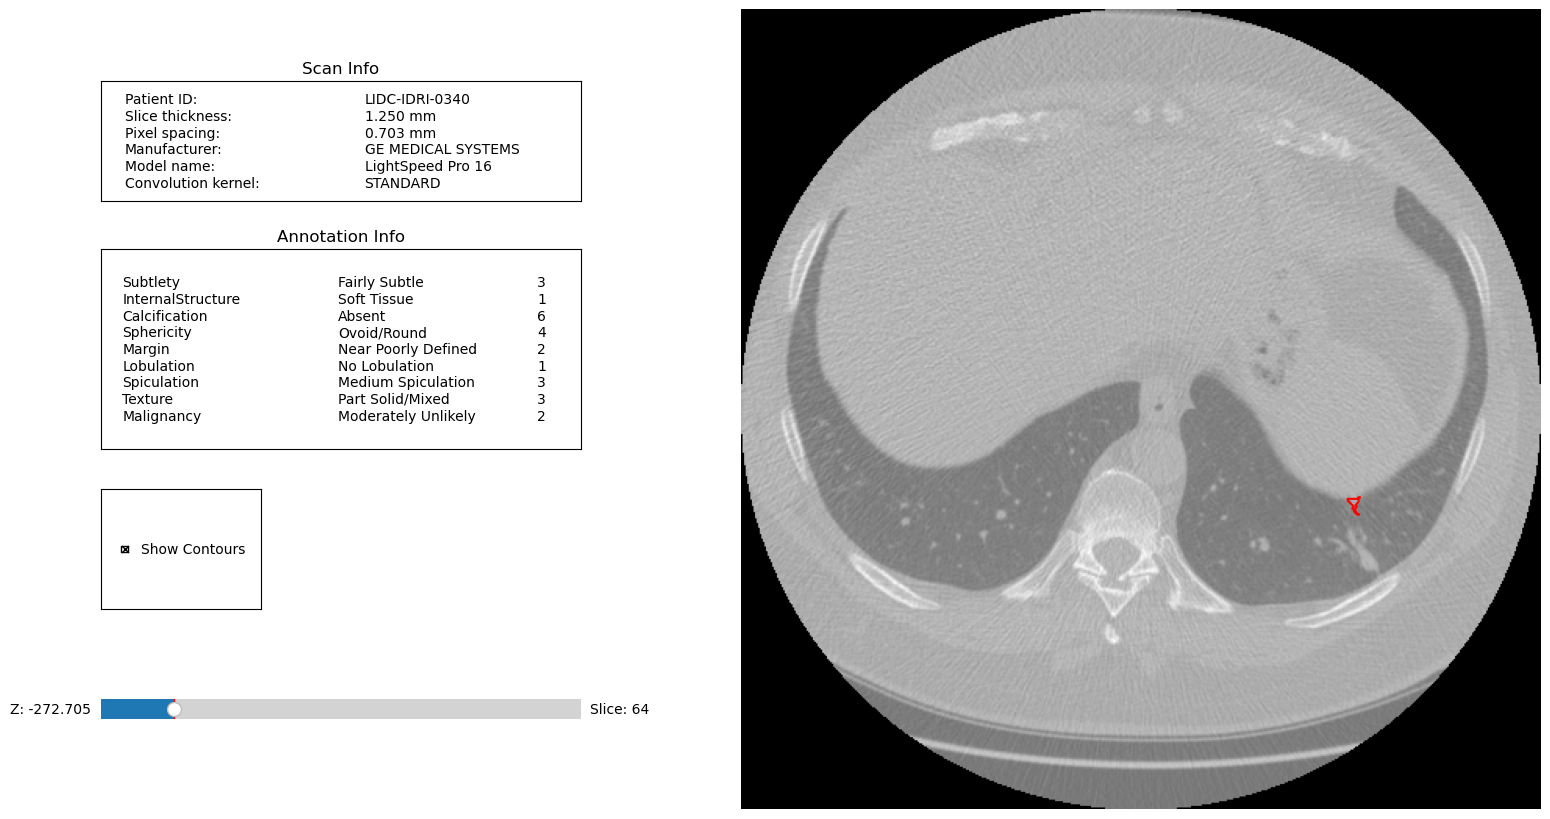

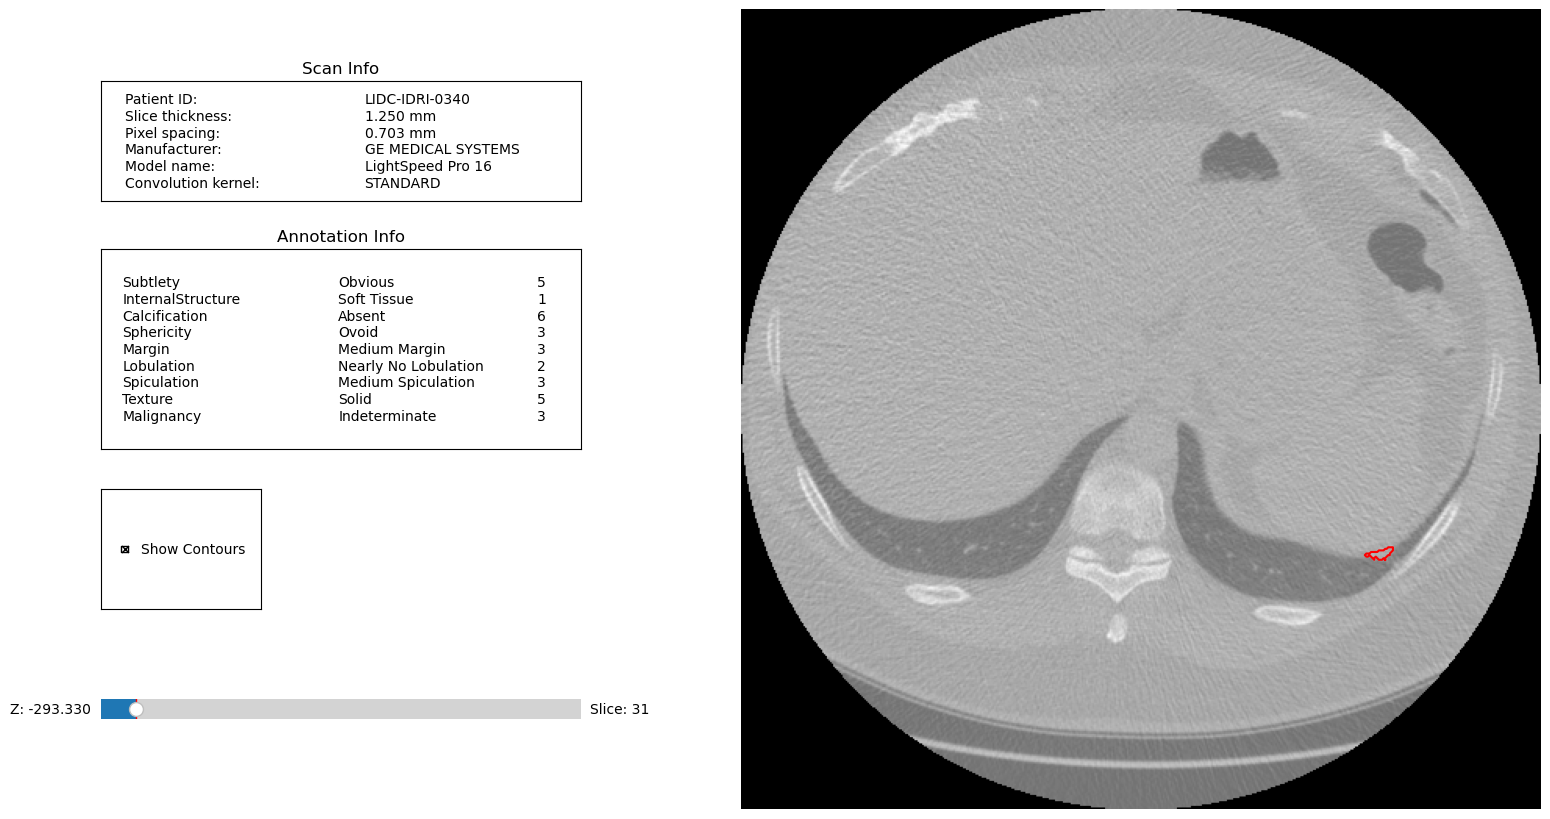

In [30]:
print_all_ann("0340", [7,8])

Como podemos ver, estas anotações estão erradas por diversos motivos, pelo que é boa ideia removê-las do dataset final.  
Sabemos que há 14 pacientes com anotações erradas, ou seja, anotações a mais.  
Será que existem pacientes sem anotações?

In [31]:
filtered = annotation_data[annotation_data['Num Annotations'] == 0]
no_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(no_nodule)} pacientes sem anotações")
print(no_nodule)

Existem 135 pacientes sem anotações
['0028' '0032' '0062' '0071' '0100' '0143' '0174' '0189' '0197' '0205'
 '0214' '0218' '0224' '0225' '0226' '0239' '0253' '0261' '0279' '0293'
 '0295' '0306' '0307' '0316' '0322' '0327' '0330' '0331' '0333' '0336'
 '0342' '0349' '0361' '0364' '0382' '0383' '0389' '0391' '0401' '0410'
 '0417' '0418' '0422' '0425' '0428' '0441' '0446' '0455' '0465' '0472'
 '0482' '0506' '0511' '0512' '0513' '0514' '0519' '0528' '0531' '0536'
 '0540' '0544' '0548' '0561' '0564' '0573' '0589' '0600' '0603' '0612'
 '0616' '0622' '0623' '0627' '0632' '0646' '0653' '0665' '0667' '0668'
 '0679' '0683' '0685' '0689' '0690' '0691' '0710' '0711' '0716' '0718'
 '0731' '0737' '0738' '0745' '0746' '0755' '0760' '0764' '0774' '0784'
 '0804' '0808' '0839' '0853' '0862' '0876' '0877' '0878' '0881' '0885'
 '0887' '0889' '0891' '0897' '0900' '0901' '0903' '0918' '0927' '0930'
 '0931' '0934' '0937' '0948' '0952' '0954' '0960' '0964' '0967' '0970'
 '0975' '0979' '0988' '0992' '0995']


**Confirmámos que os paciêntes sem nódulos estão todos incluídos na lista de paciêntes sem anotações.**

In [32]:
annotation_data.head(3)

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.5,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.5,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.5,0.703125


Foram convertidos corretamente!

### REMOÇÕES DO DATASET
Vamos remover todos os pacientes sem nodulos, estes nao nos servem para nada.  
Também vamos remover casos onde há mais de 4 anotações, como vimos anteriormente, estes acontecem por avaliação incorreta de nódulos, como vimos anteriormente. (Nódulo avaliado mal, nódulo identificado incorretamente, nódulo não identificado por completo, etc..).  
NÂO vamos remover pacientes com múltiplas entradas, pois estes vêm de diferentes TACs que um mesmo paciente fez e, portanto, podem ser tratados como casos válidos e distintos.

In [33]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}-" for s in wrong_nodule))]

Removemos 156 entradas de pacientes com nodulos mal lidos.

In [34]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}" for s in no_nodule))]

Removemos corretamente os 135 pacientes sem nodulos.
Em teoria, o dataset vai ter 6994 - 159 - 135 = 6700 entradas.

In [35]:
len(wrong_nodule)

14

Teremos também 1010 - 135 - 14 = 861 pacientes diferentes

In [36]:
annotation_data

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375
6990,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656
6991,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656
6992,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656


In [37]:
df = annotation_data.copy()
df["base_id"] = annotation_data["NoduloID"].str.extract(r"^(\d+)-")

print(f"{df['base_id'].nunique()} pacientes diferentes.")

861 pacientes diferentes.


## Merge Datasets

- **NoduleCountsByPatient** (```lidc-idri-nodule-counts-6-23-2015.xlsx```): Vai ser usado.

- **PatientDiagnoses** (```tcia-diagnosis-data-2012-04-20.xls```) : Não vai ser utilizado. Para além de só ter apenas 157 pacientes, não contém nada relevante para classificar nódulos, visto que é impossível mapear os nódulos diagnosticados com os identificados no TAC.

- **DadosPylidc** (```data.csv``` que foi gerado): Este dataset é essencial, portanto vai ser utilizado.

btw incluimos volume no DadosPylidc porque **existem** relações entre volume de um nódulo e Malignancy/Internal Structure  
https://pmc.ncbi.nlm.nih.gov/articles/PMC3941244/  
TLDR: Inclusão de volume em prediction models aumenta classificação correta de nódulos pulmonares.



Como decidimos manter os pacientes que têm vários TACs, temos de ter bastante cuidado ao dar o merge dos datasets, pois queremos que os valores estejam corretos. Para tal, decidimos deixar esses 8 pacientes em branco.

In [38]:
import pandas as pd

# Clean 'id'
nodules_clean = nodules.copy()
nodules_clean["id_clean"] = nodules_clean["Patient_ID"].str.extract(r"LIDC-IDRI-(\d+)")

# Clean 'id'
annotation_data_clean = annotation_data.copy()
annotation_data_clean["id_clean"] = annotation_data_clean["NoduloID"].str.extract(r"(\d+)-").iloc[:, 0]

# Columns to be merged from 'nodules'
nodules_cols_to_merge = ["id_clean", "Number of Nodules", "Nodules >=3mm", "Nodules <3mm"]

# Dont change lines with these IDs
mask_keep_unchanged = annotation_data_clean["id_clean"].isin(multiple_entries)
merged_keep = annotation_data_clean[mask_keep_unchanged]

# Lines to be merged (ID is NOT in multiple_entries)
annotation_data_to_merge = annotation_data_clean[~mask_keep_unchanged]

merged_data = annotation_data_to_merge.merge(
    nodules_clean[nodules_cols_to_merge],
    on="id_clean",
    how="inner" 
)

merged = pd.concat([merged_data, merged_keep], ignore_index=True)

merged = merged.drop(columns=["id_clean"])

# Save the result
merged.to_csv("merged.csv", index=False)

merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,3.0,6.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,2977.591055,3.00,0.705078,NaN,NaN,NaN
6699,0484-1,4,3.0,6.0,1.0,2.0,4.0,5.0,3.0,5.0,4.0,1709.150688,3.00,0.705078,NaN,NaN,NaN
6700,0484-1,4,5.0,6.0,1.0,4.0,4.0,5.0,5.0,5.0,5.0,2191.620363,3.00,0.705078,NaN,NaN,NaN
6701,0484-2,1,4.0,6.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,232.659256,3.00,0.705078,NaN,NaN,NaN


O número de linhas mantém-se, portanto podemos confirmar que foram juntos corretamente.

In [39]:
merged[merged.isnull().any(axis=1)]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
6589,0132-1,3,1.0,6.0,1.0,1.0,5.0,3.0,1.0,5.0,4.0,129.818916,3.0,0.537109,NaN,NaN,NaN
6590,0132-1,3,3.0,6.0,1.0,2.0,3.0,4.0,3.0,5.0,4.0,115.538836,3.0,0.537109,NaN,NaN,NaN
6591,0132-1,3,3.0,6.0,1.0,2.0,3.0,2.0,2.0,4.0,4.0,194.295645,3.0,0.537109,NaN,NaN,NaN
6592,0132-1,1,4.0,6.0,1.0,1.0,4.0,4.0,1.0,4.0,4.0,169.125366,3.0,0.546875,NaN,NaN,NaN
6593,0132-2,2,3.0,6.0,1.0,1.0,4.0,4.0,2.0,5.0,3.0,126.789808,3.0,0.537109,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,3.0,6.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,2977.591055,3.0,0.705078,NaN,NaN,NaN
6699,0484-1,4,3.0,6.0,1.0,2.0,4.0,5.0,3.0,5.0,4.0,1709.150688,3.0,0.705078,NaN,NaN,NaN
6700,0484-1,4,5.0,6.0,1.0,4.0,4.0,5.0,5.0,5.0,5.0,2191.620363,3.0,0.705078,NaN,NaN,NaN
6701,0484-2,1,4.0,6.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,232.659256,3.0,0.705078,NaN,NaN,NaN


Como não temos forma de saber qual valor no ```lidc-idri-nodule-counts-6-23-2015.xlsx``` corresponde a qual valor no ```merged.csv```, visto que apenas aparece um ```Pacient ID``` duplicado, com valores diferentes, temos de infelizmente remover estes elementos do dataset.

In [40]:
merged = merged.dropna()
merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


In [41]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

854

In [42]:
print(f"Is '{multiple_entries[3]}' in both lists: {multiple_entries[3] == wrong_nodule[5]}")

Is '0332' in both lists: True


Portanto, o numero de pacientes esta correto: 1010 - 135 (sem anotações) - 14 (anotações erradas) - 7 (repetidos) = 854.
Na verdade existem 8 repetidos, mas como existia um paciente repetido com anotações erradas, já tinha sido removido anteriormente.

In [43]:
merged[merged['Number of Nodules'] == 0]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [44]:
merged[merged['Nodules >=3mm'] == 0]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [45]:
merged[merged['Num Annotations'] > 4]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [46]:
df = merged.copy()
df["base_id"] = df["NoduloID"].str.extract(r"^(\d+)-")
df["num"] = df["NoduloID"].str.extract(r"-(\d+)$").astype(int)

# Find max number per base_id
idx = df.groupby("base_id")["num"].idxmax()

# Keep only rows with the largest suffix for each base_id
df_max = df.loc[idx, ["NoduloID", "Nodules >=3mm", "num"]].reset_index(drop=True)

df_max[df_max['Nodules >=3mm'] != df_max['num']]

,NoduloID,Nodules >=3mm,num
56,0060-6,7.0,6
166,0179-11,12.0,11
422,0491-10,9.0,10
601,0707-6,7.0,6
622,0733-8,7.0,8
638,0753-1,2.0,1
739,0867-2,3.0,2


Após confirmar que estes valores estão mesmo errados, passamos a remover todos estes pacientes do dataset, visto que o número de nódulos não é consistente.

In [47]:
mismatched_nodules = df_max[df_max['Nodules >=3mm'] != df_max['num']]['NoduloID'].astype(str).str[:4].tolist()
mismatched_nodules

['0060', '0179', '0491', '0707', '0733', '0753', '0867']

In [48]:
for n in mismatched_nodules:
    merged = merged[~merged['NoduloID'].str.startswith(n)]
merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


In [49]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

847

In [50]:
merged.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy              float64
Calcification           float64
Internal Structure      float64
Spiculation             float64
Margin                  float64
Subtlety                float64
Lobulation              float64
Texture                 float64
Sphericity              float64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules       float64
Nodules >=3mm           float64
Nodules <3mm            float64
dtype: object

Como sabemos que as caracteristicas do nodulo vao sempre ser de 0-5, é desnecessário estarem em floats.  
O número de cada tipo de nódulos também deve ser inteiro.

In [51]:
cols = merged.columns[2:11].union(merged.columns[14:17])
merged[cols] = merged[cols].apply(lambda x: x.fillna(-1).astype(int))
merged.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy                int64
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules         int64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

Resultado final é um .csv com 6491 nódulos e 847 pacientes diferentes.

In [52]:
merged.to_csv("merged.csv", encoding='utf-8', index=False)

In [53]:
merged['Malignancy'].value_counts()

Malignancy
3    2479
2    1528
1     957
4     893
5     634
Name: count, dtype: int64

Segundo a documentação do pylidc ```https://pylidc.github.io/annotation.html```, podemos ver que a pontuação atribuída a malignidade por radiologistas é caracterizada da seguinte forma:

1)  **‘Highly Unlikely’**  
2)  **‘Moderately Unlikely’**  
3)  **‘Indeterminate’**  
4)  **‘Moderately Suspicious’**  
5)  **‘Highly Suspicious’**  

Apesar de não garantirem diagnóstico definitivo, estas pontuações são úteis para avaliar a probabilidade.  
Podemos observar que é fácil criar uma identificação binária se considerarmos
- MalignancyAverage >= 3.5 -> 0
- MalignancyAverage <= 3.5 -> 1
- 2.5 < MalignancyAverage < 3.5 -> Deleted

Podem existir casos onde 3 radiologistas classificaram o nodulo como ```Highly Suspicious``` mas, como o 4º radiologista achou que era ```Indeterminate```, esse nodulo é completamente apagado. Casos onde a classificação é mesmo ambígua são apagados, mas desta forma perdemos menos informação.  
- Esta forma suaviza variância entre radiologistas.  
- Descarta nodulos verdadeiramente ambíguos.  
- Respeita a escala (aceita que 4 é "mais maligno" que 3).   
-> Tal forma de classificação vai de encontro com o nosso objetivo: decidir se um nódulo **é** ou **não** maligno.

Quanto às outras classificações, através da documentação do pylidc concluímos que todas elas estão classificadas de 1-5, sendo esta uma escala **ordenada e não ambígua**. Não faz sentido fazer mapeamento para outra escala, pois estaríamos apenas a perder informação. A única exceção é InternalStructure, mas nesse caso diferentes valores representam diferentes estruturas, sendo crucial mantê-la sem mudanças.


In [94]:
df = pd.read_csv('merged.csv')

# Calculate average malignancy for each NoduleID
malignancy_avg = df.groupby('NoduloID')['Malignancy'].mean()

def classify_malignancy(avg):
    if avg < 2:
        return 0
    elif avg > 4:
        return 1
    else:  # 2.5 <= avg <= 3.5
        return None  # Mark for deletion

# Apply classification to get the mapping
nodule_classification = malignancy_avg.apply(classify_malignancy)

# Filter out nodules that should be deleted (None values)
nodules_to_keep = nodule_classification[nodule_classification.notna()].index

# Filter the original dataframe to keep only valid nodules
df_filtered = df[df['NoduloID'].isin(nodules_to_keep)].copy()

# Update the Malignancy values based on the classification
df_filtered['Malignancy'] = df_filtered['NoduloID'].map(nodule_classification)

# Convert to boolean
df_filtered['Malignancy'] = df_filtered['Malignancy'].astype(bool)

# Display results
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nNodules removed (avg between 2.5 and 3.5): {len(df) - len(df_filtered)}")
print(f"\nUnique nodules before: {df['NoduloID'].nunique()}")
print(f"Unique nodules after: {df_filtered['NoduloID'].nunique()}")

# Show distribution of new Malignancy values
print("\nNew Malignancy distribution:")
print(df_filtered['Malignancy'].value_counts().sort_index())

df_filtered.to_csv('final.csv', index=False)

Original dataset size: 6491
Filtered dataset size: 1392

Nodules removed (avg between 2.5 and 3.5): 5099

Unique nodules before: 2519
Unique nodules after: 501

New Malignancy distribution:
Malignancy
False    845
True     547
Name: count, dtype: int64


In [88]:
df_filtered.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy                 bool
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules         int64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

In [90]:
df_filtered.head(10)

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,True,6,1,4,3,5,3,5,3,7869.369507,2.50,0.703125,4,1,3
1,0001-1,4,True,6,1,5,4,5,5,5,4,6146.438599,2.50,0.703125,4,1,3
2,0001-1,4,True,6,1,3,2,5,3,5,3,6594.474792,2.50,0.703125,4,1,3
3,0001-1,4,True,6,1,5,4,5,1,4,5,7348.411560,2.50,0.703125,4,1,3
4,0002-1,2,True,6,1,1,1,2,1,1,5,6576.900681,1.25,0.681641,12,1,11
5,0002-1,2,True,6,1,1,2,1,1,2,3,7912.434336,1.25,0.681641,12,1,11
6,0003-1,1,False,6,1,1,2,1,1,1,5,4731.410934,2.50,0.820312,4,4,0
7,0003-2,4,True,6,1,2,3,5,2,3,3,5190.673222,2.50,0.820312,4,4,0
8,0003-2,4,True,6,1,2,3,5,2,5,4,4625.427330,2.50,0.820312,4,4,0
9,0003-2,4,True,6,1,3,3,5,3,4,4,5649.935511,2.50,0.820312,4,4,0


In [93]:
df_filtered.nunique()

NoduloID                1212
Num Annotations            4
Malignancy                 2
Calcification              6
Internal Structure         3
Spiculation                5
Margin                     5
Subtlety                   5
Lobulation                 5
Texture                    5
Sphericity                 5
Volume                  2934
Slice Thickness (mm)      11
Pixel Resolution         188
Number of Nodules         41
Nodules >=3mm             18
Nodules <3mm              35
dtype: int64

### References
[^1]: https://www.sciencedirect.com/science/article/abs/pii/S1566253516301063
